### 타이타닉 모델링 및 성능 평가

### 1) 첫번째 -> RandomForestClassifier

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
import pandas as pd
train = pd.read_csv('./dataset/train.csv')
train.head(3)
# RangeIndex는 DataFrame 인덱스 범위를 나타내므로 전체 row 수를 알 수 있다
# 총 891행 cloumn 수는 12개 
# object type은 string으로 봐도 무방
# Age, Cabin, Embarked에 Null값 확인 --> 처리해줘야 함

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [28]:
### Age는 평균값으로 대체
train['Age'].fillna(train['Age'].mean(), inplace = True)

### 나머지는 'N'으로 대체
train['Cabin'].fillna('N', inplace=True)
train['Embarked'].fillna('N', inplace=True)
print('데이터 세트 null 값 개수', train.isnull().sum().sum())

데이터 세트 null 값 개수 0


In [7]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
train.Cabin.value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [9]:
train.Embarked.value_counts()

S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64

In [29]:
train.Cabin = train.Cabin.str[:1] # 0번째 index값 -> 문자 첫글자만 추출
train.Cabin

0      N
1      C
2      N
3      C
4      N
      ..
886    N
887    B
888    N
889    C
890    N
Name: Cabin, Length: 891, dtype: object

### ML 알고리즘을 적용해 예측을 수행 하기전 데이터 탐색
- 어떤 유형의 승객이 생존 확률이 높았을까?
- 성별이 생존 확률에 어떤 영향을 미쳤을까?

In [30]:
train.groupby(['Sex','Survived'])['Survived'].count().to_frame()

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

In [31]:
train.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [32]:
train.groupby(['Sex','Survived'])['Age'].mean()

Sex     Survived
female  0           26.023272
        1           28.979263
male    0           31.175224
        1           27.631705
Name: Age, dtype: float64

In [33]:
train.groupby(['Pclass','Sex'])['Survived'].count()

Pclass  Sex   
1       female     94
        male      122
2       female     76
        male      108
3       female    144
        male      347
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

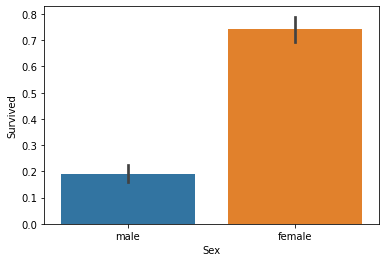

In [34]:
# 시각화 
sns.barplot(x='Sex',y='Survived', data=train)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

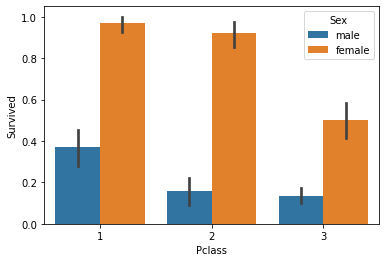

In [35]:
# hue parameter를 추가하여 여러개의 막대를 표시할 수도 있습니다.
sns.barplot(x='Pclass', y='Survived', hue='Sex',data=train)

# 여성의 경우 Pclass별 생존 확률의 차이는 크지 않으나, 삼등석의 경우 상대적으로 생존 확률이 많이 떨어짐
# 남성의 경우 1등석이 2, 3등석보다 월등히 높다

<AxesSubplot:xlabel='Age', ylabel='Survived'>

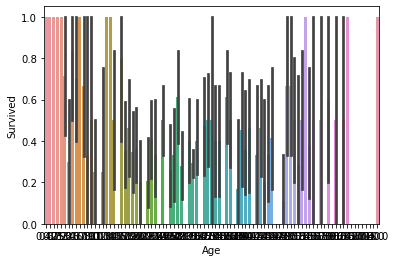

In [36]:
# 나이 범주화 해줘야함 -> 값의 종류가 많아 범위별로 분류해 카테고리 값을 할당
sns.barplot(x='Age', y='Survived', data=train)

In [18]:
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown' # -1 이하의 오류 값은 Unknown으로 분류
    elif age <=5: cat = 'Baby'
    elif age <=12: cat = 'Child'
    elif age <=18:  cat = 'Teenager'
    elif age <=25: cat = 'Student'
    elif age <=35: cat = 'Young Adult'
    elif age <=60: cat = 'Adult'
    else: cat ='Elderly'
        
    return cat

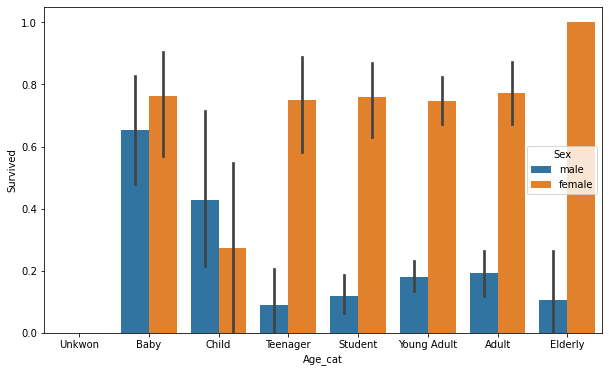

In [37]:
plt.figure(figsize=(10,6))

# x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unkwon','Baby','Child', 'Teenager','Student','Young Adult','Adult','Elderly']

# lambda 식에 위에서 생성한 get_categroy()함수를 반환값으로 지정.
# get_category(x)는 입력값으로 'Age' 컬럼 값을 받아서 해당하는 cat 반환

train['Age_cat'] = train.Age.apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=train, order=group_names)
train.drop('Age_cat', axis=1, inplace=True)

# Sex, Agem PClass 등 중요하게 생존을 좌우하는 피처임을 확인함

- 여자 Baby의 경우에는 비교적 생존률이 높고, Child의 경우 생존률이 낮음, Elderly의 경우에는 생존률이 매우 높음

- Sex, Age, Pclass 등이 생존 여부에 중요한 Feature인 것으로 보임

- 이제 남아있는 문자열 카테고리 Feature를 숫자형으로 변환 --> 사이킷런의 LabelEncoder() 이용

- LabelEncoder 객체는 카테고리 값의 유형수에 따라 0 ~ (유형수-1) 까지 숫자 값으로 변환

In [38]:
# 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환 -> 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF) :
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

train = encode_features(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [39]:
# 지금까지 피처를 가공한것을 통합 함수로 만들어 쉽게 재사용할 수 있도록 함
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df


# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df


# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [ ]:
# 데이터 전처리
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

def get_category(age):
    cat =''
    if age<10: 
        cat = 'Child'
    elif 10 <= age < 20:
        cat = 'Teenage'
    elif 20 <= age < 30:
        cat ='Twenty'
    elif 30 <= age < 40:
        cat = 'Thirty'
    elif 40 <= age < 50:
        cat = 'Forty'
    elif 50 <= age < 60:
        cat = 'Elderly'
    return cat

df = pd.read_csv('./dataset/train.csv')

df['Title'] = df.Name.apply(lambda x: re.search('([A-Za-z]+)\.', x).group(0).strip()) # Title에 정규표현식 적용 
df['Family'] = df['SibSp']+df['Parch'] # 열 병합 후  df['Family']로 넣어줌
df = df.drop(['SibSp', 'Parch'], axis=1) # 열 삭제
df = df.drop(['Ticket','Name','PassengerId','Cabin'], axis=1)


df['Age'] = df.groupby(['Pclass','Sex','Title'])['Age'].apply(lambda x: x.fillna(x.mean()))
df['Embarked'].fillna('S', inplace = True)
df['Age_cat'] = df['Age'].apply(lambda x: get_category(x))
cnt, bins = np.histogram(df.Fare, bins=5)

df['Fare_bins'] = pd.cut(x=df.Fare, bins=bins, labels=[0,1,2,3,4], include_lowest=True)
df = df.drop(['Age', 'Title'], axis=1)

features = ['Sex','Embarked', 'Age_cat'] # LabelEncoder
for feature in features:
    le = LabelEncoder()
    le.fit(df[feature])
    df[feature] = le.transform(df[feature])

# df = pd.get_dummies(df[['Pcalss','Sex','Embarked','Age_cat','Fare_bins']])
display(df)

In [42]:
# 원본 데이터 재로딩
titanic_df = pd.read_csv('./dataset/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop(['Survived'], axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

##### ML 알고리즘인 DecisionTree, RandomForest, Logistic Regression을 이용하여 생존자 예측

- train_test_split() 으로 분리한 학습 데이터와 테스트 데이터를 기반으로 머신러닝 모델을 학습(fit)하고, 예측(predict)
- 성능평가는 정확도로 평가: accuracy_score() 를 사용

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

# DecisionTree, RandomForest, LogisticRegression을 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred))) # 실제값, 예측값
      
# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
      
# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도 : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
LogisticRegression 정확도 : 0.8492


In [48]:
# 교차 검증을 위한 kFold 클래스를 사용
from sklearn.model_selection import KFold

def exec_kfold(clf, folds):
    # 폴드 세트가 5개인 kFold 객체 생성, 폴드 수 만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # kFold 교차검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_train_df 데이터에서 교차검증별로 학습과 검증 데이터를 가리키는 인덱스 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
        # 5개 fold에서 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도 : {0:.4f}".format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, 5)

교차검증 0 정확도: 0.7542
교차검증 1 정확도: 0.7809
교차검증 2 정확도: 0.7865
교차검증 3 정확도: 0.7697
교차검증 4 정확도: 0.8202
평균 정확도 : 0.7823


In [49]:
# 교차 검증을 위한 cross_val_score() 사용
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
print("평균정확도: {0: .4f}".format(np.mean(scores)))

교차검증 0 정확도: 0.7430
교차검증 1 정확도: 0.7753
교차검증 2 정확도: 0.7921
교차검증 3 정확도: 0.7865
교차검증 4 정확도: 0.8427
평균정확도:  0.7879


###### kFold와 cross_val_score의 점수가 다른 것은, cross_val_score 는 StratifiedKFold를 이용해 세트를 분할하기 때문

##### GridSearchCV를 이용하여 DecisionTreeClassifier 최적 하이퍼 파라미터를 찾고, 예측 성능을 측정

- CV = 5로 지정하고, max_depth, min_samples_split, min_samples_leaf를 변경하면서 성능을 측정
- 최적 하이퍼 파라미터와 그 때의 예측을 출력하고, 최적 하이퍼파라미터로 학습된 Estimator를 이용해 위의 train_test_split()으로 분리된 테스트 데이터 세트에 예측을 수행하여 정확도 측정

In [50]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2, 3, 5, 10],
                        'min_samples_split' : [2, 3, 5],
                         'min_samples_leaf' : [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print("GridSearch 최적 하이퍼 파라미터: ", grid_dclf.best_params_)
print("GridSearch 최고 정확도:{:.4f} ".format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearch의 최적 하이퍼파라미터로 학습된 Estimator로 예측 및 평가 수행
predictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))

GridSearch 최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearch 최고 정확도:0.7992 
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715


- 최적 하이퍼 파라미터인 max_depth = 3, min_samples_leaf = 5, min_samples_split = 2로 DecisionClassifier를 학습시킨 뒤 모델 정확도가 약 87.15%로 향상

- 실제로는 하이퍼 파라미터 튜닝으로 스코어가 이렇게 증가하지는 않음